In [1]:
import torch
import numpy as np
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

In [2]:
import time
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import network_v2 as networks
net = networks.OcclusionAwareVS(angular=7, dmax=4, use_cuda=False)

In [5]:
def prepare_image(img):
    return torch.clamp(img, 0, 1).permute((1,2,0)).cpu().detach().numpy()


In [6]:
def process(testloader, test_datset, net, scale=1., offset=0.):
    
    it = iter(testloader)
    psnrs = []
    for i in range(len(test_dataset)):
        
        print("Sample: ", i)

        with torch.no_grad():

            epoch_start_time = time.time()    

            sample = it.next()
            prediction = net.forward(sample['p'], sample['q'],
                                     sample['c1'], sample['c2'], sample['c3'], sample['c4'])

            print("Processing time:", time.time()-epoch_start_time, " seconds.")

            # compute PNSR
            pred = (prediction[0]+offset)*scale
            print(pred.max(), pred.min(), pred.mean())
            gt = (sample['ground_truth']+offset)*scale
            print(gt.max(), gt.min(), gt.mean())
            if torch.cuda.is_available():
                pred = pred.cuda()
                gt = gt.cuda()

            psnr = -10*torch.log10(torch.mean((pred-gt)**2))
            with np.printoptions(precision=2):
                print(psnr)
            psnrs.append(psnr)

            d = prediction[3]
            fig = plt.figure(figsize=(30,15))
            plt.subplot(2,3,1)
            plt.imshow(prepare_image(gt[0,:,:,:]))
            plt.subplot(2,3,4)
            plt.imshow(prepare_image(pred[0,:,:,:]))
            plt.subplot(2,3,2)
            plt.imshow(prepare_image((d[0,0:1,:,:]*.25+1)*.5)[...,0], cmap='gray')
            plt.subplot(2,3,3)
            plt.imshow(prepare_image((d[0,1:2,:,:]*.25+1)*.5)[...,0], cmap='gray')
            plt.subplot(2,3,5)
            plt.imshow(prepare_image((d[0,2:3,:,:]*.25+1)*.5)[...,0], cmap='gray')
            plt.subplot(2,3,6)
            plt.imshow(prepare_image((d[0,3:4,:,:]*.25+1)*.5)[...,0], cmap='gray')
            plt.show()
            
    return psnrs

    

# MODEL 1: Trained on California dataset

### Go down for the second model.

In [69]:
import data_preload as data
path_to_data = 'Demo/'

num_workers = 2
test_batch_size = 1

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [70]:
n = "model_corr_b3_no_corners_no_decay_grad"
path_to_best_model = "./"+n+"_best"


In [71]:
checkpoint = torch.load(path_to_best_model, map_location=torch.device('cpu')) # path_to_best_model

net.load_state_dict(checkpoint['model_state_dict'])
print("MSE train:", checkpoint['mse_train'])
print("MSE valid:", checkpoint['mse_validation'])
print('Model loaded.')

net.eval()

MSE train: 0.00023261756141437217
MSE valid: 0.0002674322039920612
Model loaded.


OcclusionAwareVS(
  (fen): FeatureExtraction(
    (layer0): Sequential(
      (0): Sequential(
        (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer1): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer3): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [72]:
# test_dataset = data.LightFieldDataset(root_dirs=[path_to_data+'test-flowers/'], angular=7,
test_dataset = data.LightFieldDataset(root_dirs=["/home/milanstepanov/Documents/Code/Deliverable_2_1/Demo/"], angular=7,
                                       transform=Compose([
                                           data.SelectView(7, 3,3),
                                           data.Gamma(.4),
                                           data.ToTensor()
                                       ]))
print("Test set load done.")
testloader = DataLoader(test_dataset, batch_size=test_batch_size,
                              num_workers=num_workers, worker_init_fn=worker_init_fn)

Test set load done.


In [73]:
len(test_dataset)

1

Sample:  0
Processing time: 11.913354396820068  seconds.
tensor(1.0000) tensor(0.) tensor(0.3363)
tensor(1.) tensor(0.) tensor(0.3361)
tensor(37.7562)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f2ee789d8>
Traceback (most recent call last):
  File "/home/milanstepanov/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/milanstepanov/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/milanstepanov/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/milanstepanov/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/milanstepanov/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


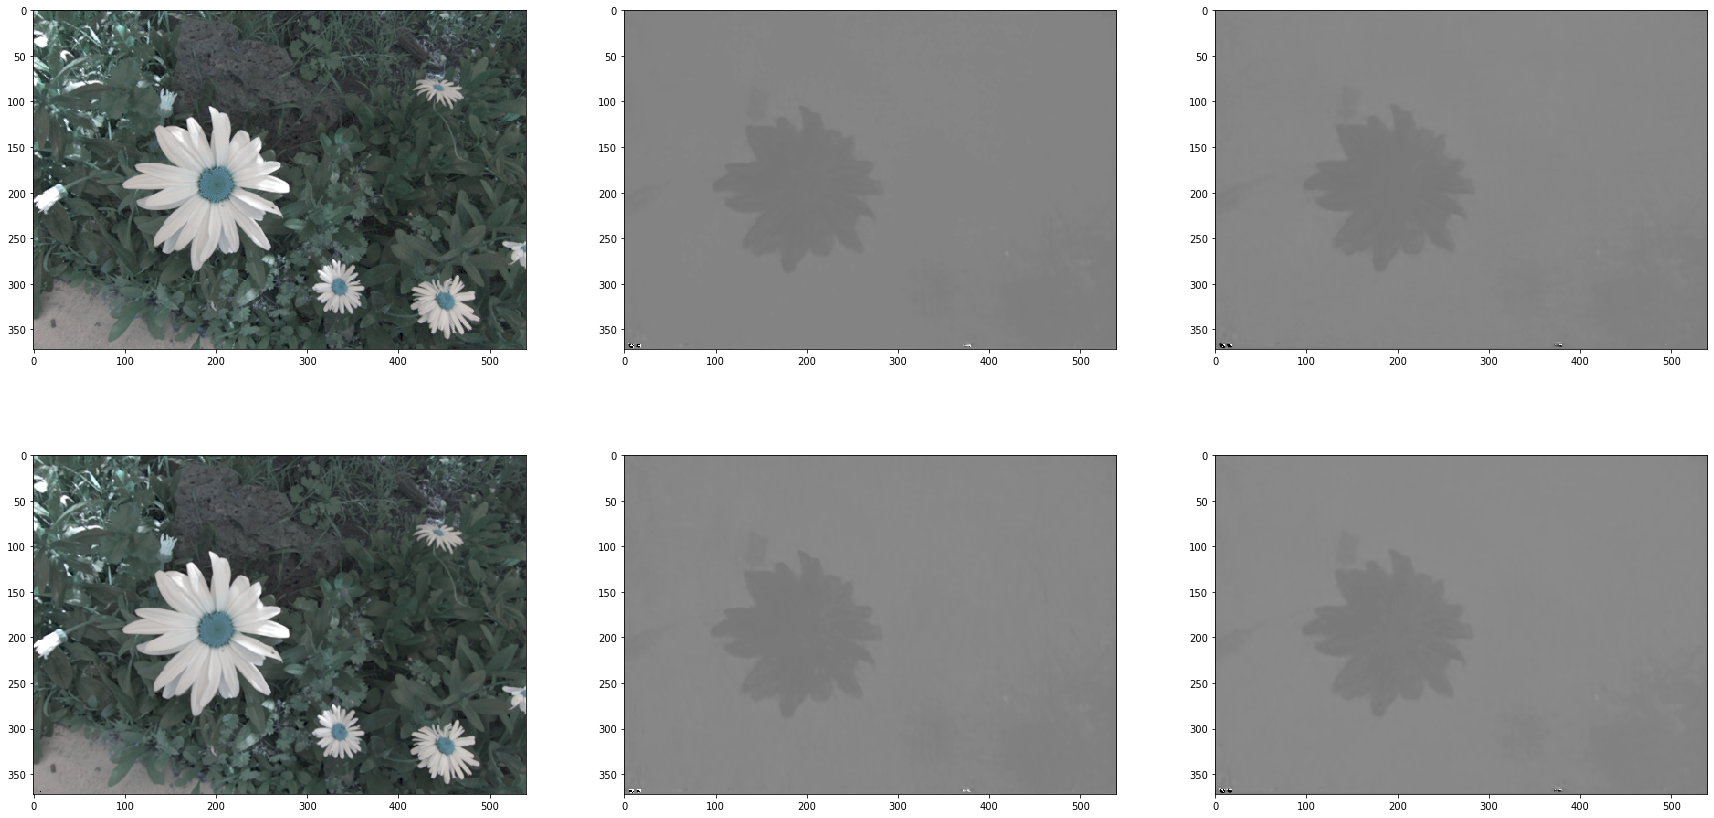

In [74]:
psnrs = process(testloader, test_dataset, net)

In [75]:
for psnr in psnrs:
    with np.printoptions(precision=1):
        print(psnr.numpy())

37.756172


# MODEL 2: Trained on Flowers dataset

### Go down for the second model.

In [7]:
import data_load as data
path_to_data = 'Demo/'

num_workers = 2
test_batch_size = 1

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [8]:
n = "model_corr_b3_no_corners_no_decay_grad_flowers_gamma"
path_to_best_model = "./"+n+"_best"


In [9]:
checkpoint = torch.load(path_to_best_model, map_location=torch.device('cpu')) # path_to_best_model

net.load_state_dict(checkpoint['model_state_dict'])
print("MSE train:", checkpoint['mse_train'])
print("MSE valid:", checkpoint['mse_validation'])
print('Model loaded.')

net.eval()

MSE train: 0.00040903258786644214
MSE valid: 0.0006260994559852406
Model loaded.


OcclusionAwareVS(
  (fen): FeatureExtraction(
    (layer0): Sequential(
      (0): Sequential(
        (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer1): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ELU(alpha=1.0)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer3): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [33]:
# test_dataset = data.LightFieldDataset(root_dirs=[path_to_data+'test-flowers/'], angular=7,
test_dataset = data.LightFieldDataset(root_dirs=["/home/milanstepanov/Documents/Code/Deliverable_2_1/Demo/"], angular=7,
                                       transform=Compose([
                                           data.LoadLF(),  # load 0-255
                                           data.SelectView(7, 0,0), # select views 0-255
                                           data.Gamma(.4), # [0,1], gamma, [0,255]
                                           data.ToTensor(normalize=False) # scale [-.5, 1.5]
                                       ]))
print("Test set load done.")
testloader = DataLoader(test_dataset, batch_size=test_batch_size,
                              num_workers=num_workers, worker_init_fn=worker_init_fn)

len(test_dataset)

Test set load done.


1

In [40]:
(test_dataset[0]['c1'][:,1,0]*255).byte()

tensor([197, 214, 214], dtype=torch.uint8)

In [11]:
sample = iter(testloader).next()

In [12]:
prediction = net.forward(sample['p'], sample['q'],
                         sample['c1'], sample['c2'], sample['c3'], sample['c4'])

In [21]:
k = sample['c1'][0,0,10:20,10:20]

In [25]:
k[0,:]

tensor([ 0.5431,  0.3784,  0.1196,  0.0176,  0.0412,  0.0176, -0.0294, -0.0922,
         0.0412,  0.1039])

In [17]:
sample['c2'].mean()

tensor(0.1740)

Sample:  0
Processing time: 11.831063508987427  seconds.
tensor(1.) tensor(2.7716e-06) tensor(0.3367)
tensor(1.) tensor(0.) tensor(0.3363)
tensor(37.9954)


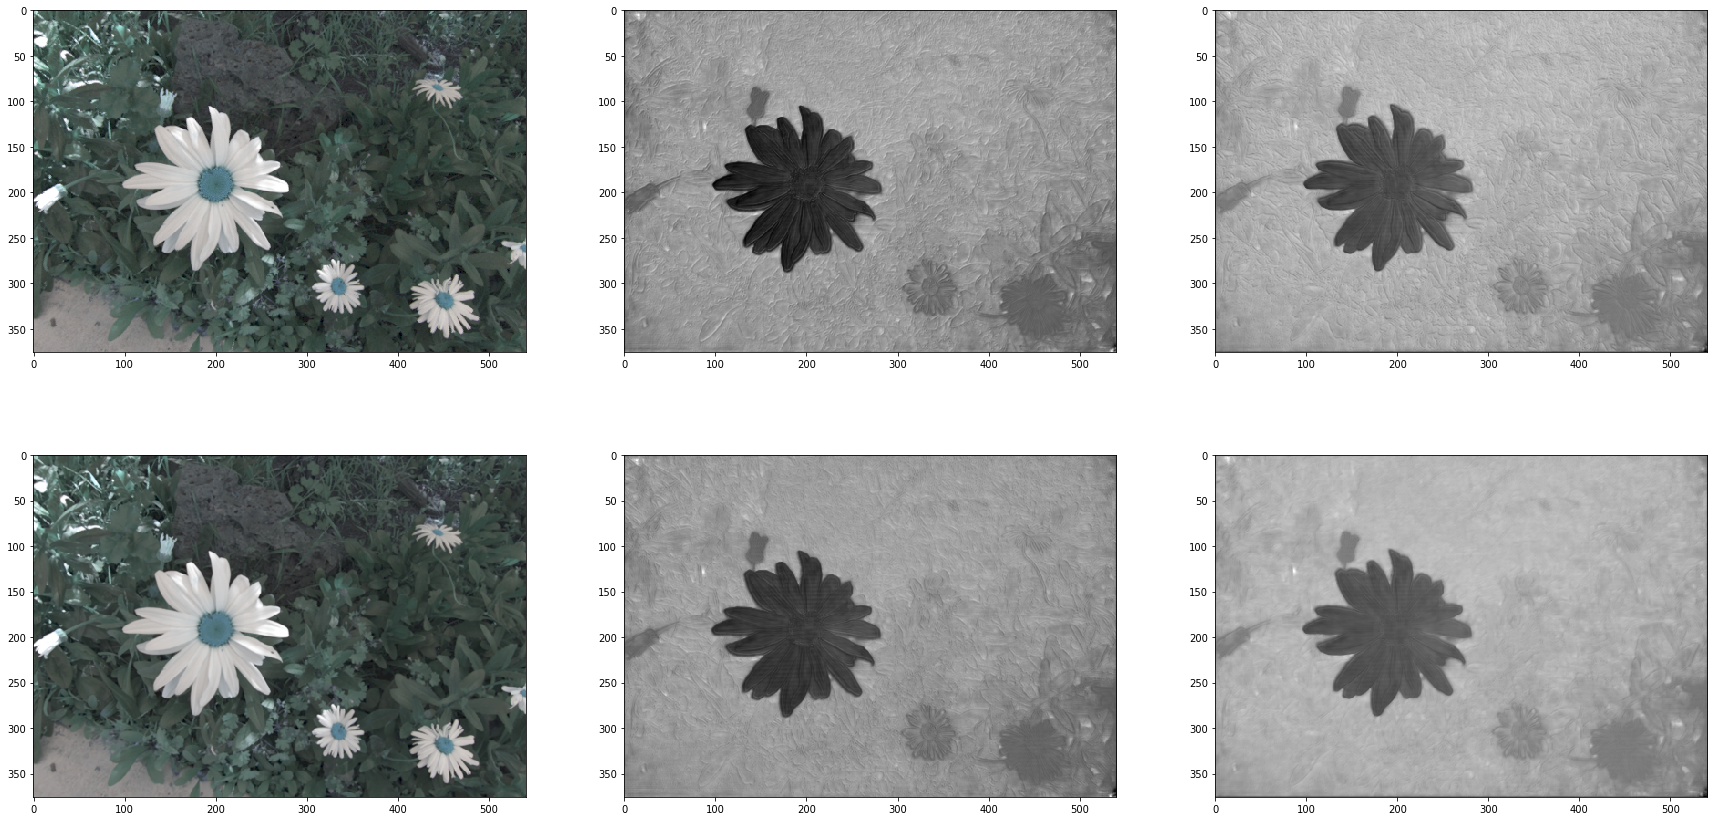

In [17]:
psnrs = process(testloader, test_dataset, net, .5, .5)

In [23]:
def normalize(img, offset, scale):
    return (img+offset)*scale

psnrs = np.zeros((7,7,1))
names = []
bad_order = False
for u in range(7):
    for v in range(7):
        # create dataset and loader
        td = data.LightFieldDataset(root_dirs=["/home/milanstepanov/Documents/Code/Deliverable_2_1/Demo/"], angular=7,
                                       transform=Compose([
                                           data.LoadLF(),
                                           data.SelectView(7, v, u),
                                           data.Gamma(.4),
                                           data.ToTensor(gamma=False, gamma_min=0.4, gamma_max=.5, normalize=True)
                                       ]))
        print("Test set load done.")
        tl = DataLoader(td, batch_size=test_batch_size, num_workers=num_workers, worker_init_fn=worker_init_fn)
        
        it = iter(tl)
        tmp_names = []
        for i in range(len(td)):

            with torch.no_grad():

                sample = it.next()
                prediction = net.forward(sample['p'], sample['q'],
                                 sample['c1'], sample['c2'], sample['c3'], sample['c4'])
        
                # compute PNSR
                pred = normalize(prediction[0], .5, .5)
                gt = normalize(sample['ground_truth'], .5, .5)

                psnrs[v,u,i] = -10*torch.log10(torch.mean((pred-gt)**2))
                tmp_names.append(sample['filename'])
                
        if len(names):
            # not empty
            for (name, tmp_name) in zip(names, tmp_names):
                if not (name==tmp_name):
                    print("Bad order.")
                    bad_order = True
                    break
                
            
        else:
            names = tmp_names
            
        if bad_order:
            break
            
            
    if bad_order:
        break
        

Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.
Test set load done.


In [24]:
with np.printoptions(precision=3):
    print(psnrs[:,:,0])

[[56.085 40.067 39.053 39.318 39.351 40.343 49.281]
 [40.104 38.936 38.403 38.603 38.789 39.275 40.226]
 [38.654 38.474 38.115 38.145 38.444 38.864 38.866]
 [38.353 38.447 38.157 37.995 38.458 38.774 38.649]
 [38.635 38.62  38.225 38.095 38.278 38.629 38.625]
 [39.999 39.049 38.528 38.533 38.371 38.552 39.238]
 [47.877 40.02  39.075 39.088 38.692 39.171 46.786]]
